In [154]:
import pandas as pd
import numpy as np
import seaborn as sb
from scipy.signal import wiener
import matplotlib.pyplot as plt
import re

from bokeh.io import output_notebook, show
from bokeh.charts import Scatter, Line

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_distances

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from pandas_ml import ConfusionMatrix

regex = re.compile('[^a-zA-Z ]')

def remove_duplicate_dates(df, value_text):
    cur_date = None
    vals = []
    dates = []
    for index, row in df.iterrows():
        if row['Date'] != cur_date:
            vals.append(row[value_text])
            dates.append(row['Date'])
            cur_date = row['Date']
    return pd.Series(vals), dates

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic {}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

def get_top_words(model, feature_names, n_top_words):
    top_words = []
    for topic_idx, topic in enumerate(model.components_):
        top_words.extend([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    return top_words

def join_text_on_date(df):
    dates = [None]
    titles = []
    bodies = []
    fmp = []
    fmd = []
    for index, row in df.iterrows():
        if row['Date'] == dates[-1]:
            titles[-1] = titles[-1] + row['Title']
            bodies[-1] = bodies[-1] + row['Body']
        else:
            dates.append(row['Date'])
            fmp.append(row['Filtered Mean Proportion'])
            fmd.append(row['Filtered Mean Delta'])
            titles.append(row['Title'])
            bodies.append(row['Body'])
    return pd.DataFrame({'Date': dates[1:], 'Title': titles, 'Body': bodies, 
                         'Filtered Mean Proportion': fmp, 'Filtered Mean Delta': fmd})

def train_test_split(df):
    all_indices = np.arange(len(df))
    train_indices = np.random.choice(all_indices, 9 * len(all_indices) // 10)
    test_indices = np.setdiff1d(all_indices, train_indices)
    test_df = df.iloc[test_indices]
    df.iloc[test_indices].to_csv('data/dataset-test.csv', index=False)
    df.iloc[train_indices].to_csv('data/dataset-train.csv', index=False)

In [9]:
output_notebook()

Loading BokehJS ...

In [164]:
df = pd.read_csv('data/dataset-train.csv').dropna()
df['Title'] = df['Title'].apply(lambda s: s + ' ')
df['Body'] = df['Body'].apply(lambda post: regex.sub('', post).lower())
df['Body'] = df['Body'].apply(lambda s: s + ' ')
df = df.sort_values(by='Date', ascending=False)

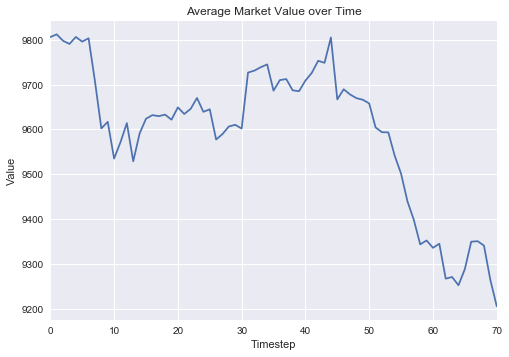

In [11]:
nasdaq_values = df[['Date','Nasdaq Value']]
sp_values = df[['Date','S&P 500 Value']]
dowjones_values = df[['Date','Dow Jones Value']]
nasdaq_values, dates = remove_duplicate_dates(nasdaq_values, 'Nasdaq Value')
sp_values, dates = remove_duplicate_dates(sp_values, 'S&P 500 Value')
dowjones_values, dates = remove_duplicate_dates(dowjones_values, 'Dow Jones Value')
mean_values = (nasdaq_values + dowjones_values + sp_values)/3
# sb.tsplot(nasdaq_values)
# sb.tsplot(dowjones_values)
# sb.tsplot(sp_values)
sb.tsplot(mean_values)
plt.title('Average Market Value over Time')
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.show()

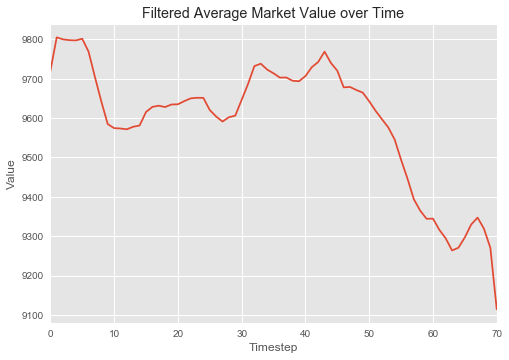

In [165]:
# Filter Values and Reassign
# Filter after averaging
filtered_mean_values = wiener(mean_values, noise=None)
mean_values_df = pd.DataFrame({'Filtered Mean Value': filtered_mean_values, 'Mean Value': mean_values,
                               'Date': dates})
mean_values_df['Filtered Mean Delta'] = -mean_values_df['Filtered Mean Value'].diff(periods=1)
mean_values_df['Mean Delta'] = -mean_values_df['Mean Value'].diff(periods=1)

nasdaq_delta = nasdaq_values.diff(periods=1)
sp_delta = sp_values.diff(periods=1)
dowjones_delta = dowjones_values.diff(periods=1)
mean_values_df['Filtered Mean Proportion'] =  (nasdaq_delta/nasdaq_values + sp_delta/sp_values 
                                               + dowjones_delta/dowjones_values)/3
mean_values_df['Mean Proportion'] = mean_values_df['Mean Delta'] / mean_values_df['Mean Value']

df = pd.merge(df, mean_values_df, on='Date', how='left').dropna()
sb.tsplot(filtered_mean_values)
plt.title('Filtered Average Market Value over Time')
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.show()

In [13]:
# Vectorize Blog Posts with BOW 
initial_vectorizer = CountVectorizer(stop_words='english', min_df=0.05, max_df=0.8)
data = initial_vectorizer.fit_transform(df['Body'])

In [14]:
distances = cosine_distances(data)
mds = MDS(n_components=2, dissimilarity='precomputed')
pos = mds.fit_transform(distances)

In [15]:
lda = LatentDirichletAllocation(n_topics=5, random_state=42, learning_method='online')
topic_scores = lda.fit_transform(data)
labels = np.argmax(topic_scores, axis=1)
df['Topic Label'] = labels

In [155]:
print_top_words(lda, initial_vectorizer.get_feature_names(), 20)


Topic 0:
order secretary united states executive federal law shall state security national agency department agencies director house office regulatory section policy

Topic 1:
think spicer going people thats just dont said im know mr theres hes house question sean sure presidents clear make

Topic 2:
trump united states american people america today minister vice donald prime security country americans great gorsuch world women day national

Topic 3:
going thank great people want know applause american thats just right im country really good think like jobs dont mr

Topic 4:
administration official tax going think just american thats make senior government question china economic said secretary order important steel like



In [17]:
lda_df = {'x':pos[:, 0], 'y':pos[:,1], 'label':labels}
show(Scatter(lda_df, x='x', y='y', color='label', title='LDA Clusters - Trump'))

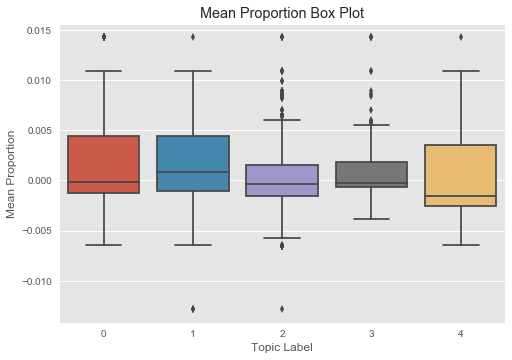

In [171]:
sb.boxplot(x="Topic Label", y="Mean Proportion", data=df)
plt.title('Mean Proportion Box Plot')
plt.show()

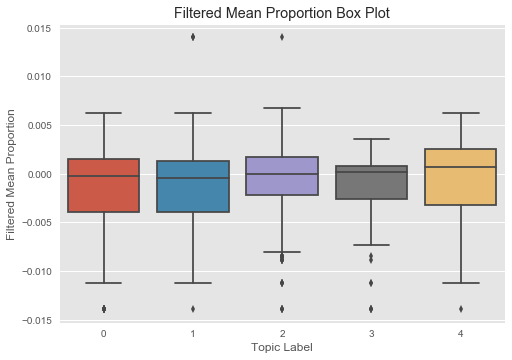

In [168]:
sb.boxplot(x="Topic Label", y="Filtered Mean Proportion", data=df)
plt.title('Filtered Mean Proportion Box Plot')
plt.show()

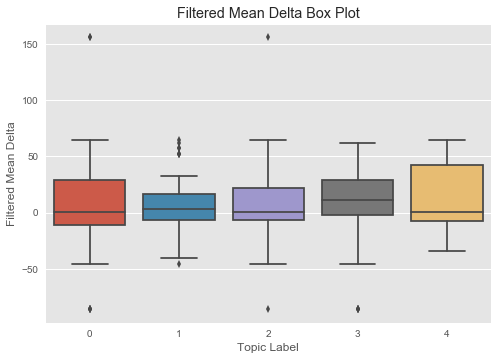

In [169]:
sb.boxplot(x="Topic Label", y="Filtered Mean Delta", data=df)
plt.title('Filtered Mean Delta Box Plot')
plt.show()

In [19]:
df[df['Topic Label'].apply(lambda x: True if x in (0,1,3) else False)].groupby('Date')['Title'].sum()

Date
2017-01-23    Presidential Memorandum Regarding the Mexico C...
2017-01-24    Executive Order Expediting Environmental Revie...
2017-01-25    Vice President Mike Pence Announces Andrea Tho...
2017-01-26    Budgetary Impact Analysis for Executive Order ...
2017-01-30    Senate Democrats Obstruct President Trump’s No...
2017-01-31    President Donald J. Trump Announces Intent to ...
2017-02-01    Remarks by President Trump and Vice President ...
2017-02-02    Press Briefing by Press Secretary Sean Spicer,...
2017-02-03    Presidential Executive Order on Core Principle...
2017-02-06    Remarks by President Trump to Coalition Repres...
2017-02-07    Readout of the Vice President's Meeting with R...
2017-02-08    Intel Announces $7 Billion Investment Creating...
2017-02-09    Presidential Executive Order on Preventing Vio...
2017-02-13    Budgetary Impact Analysis for Executive Order ...
2017-02-14    Remarks by President Trump at Signing of H.J. ...
2017-02-15    Remarks by President 

In [20]:
# Revectorize Blog Posts to Label each post with a topic
topic_vectorizer = CountVectorizer(vocabulary=set(get_top_words(lda, initial_vectorizer.get_feature_names(), 50)))
data = topic_vectorizer.transform(df['Body'])
distance = cosine_distances(data)
pos = mds.fit_transform(distance)

In [21]:
topic_df = pd.DataFrame({'x':pos[:,0], 'y':pos[:,1], 'label':df['Topic Label']})
show(Scatter(topic_df, x='x', y='y', color='label', title='Topic Feature Space Clusters - Trump'))

In [40]:
# Add Decision Tree Here
# Create Positive Example Set and Negative Example Set

In [22]:
# If so, filter the blog posts based on topic first
data_df = df[df['Topic Label'].apply(lambda x: True if x in (0,1,3) else False)][['Date', 'Title', 'Body', 'Filtered Mean Proportion', 'Filtered Mean Delta']]
data_df

,Date,Title,Body,Filtered Mean Proportion,Filtered Mean Delta
9,2017-05-02,President Donald J. Trump Approves Resighini R...,today president donald j trump declared that a...,0.001544,-86.105704
10,2017-05-02,Remarks by President Trump at Presentation of ...,rose garden am edtthe president thank you very...,0.001544,-86.105704
11,2017-05-02,Two Nominations Sent to the Senate,nominations sent to the senatemarshall billing...,0.001544,-86.105704
12,2017-05-02,ICYMI: WSJ Ed Board on How AHCA Covers People ...,liberals are inflating the preexisting conditi...,0.001544,-86.105704
13,2017-05-02,Two Nominations Sent to the Senate,nominations sent to the senatemarshall billing...,0.001544,-86.105704
14,2017-05-02,H.R. 1180 – Working Families Flexibility Act o...,may housestatement of administration policyhr...,0.001544,-86.105704
15,2017-05-02,Remarks by President Trump at Presentation of ...,rose garden am edtthe president thank you very...,0.001544,-86.105704
16,2017-05-02,Two Nominations Sent to the Senate,nominations sent to the senatemarshall billing...,0.001544,-86.105704
17,2017-05-01,Remarks by the Vice President to Small Busines...,institute of peacewashington dc pm edtthe vice...,-0.001183,5.140055
21,2017-05-01,Presidential Executive Order on the Establishm...,executive order establishment of the amer...,-0.001183,5.140055


In [158]:
# Join the blog posts that are on the same day
joined_data_df = join_text_on_date(df)[['Date', 'Title', 'Body', 'Filtered Mean Delta', 'Filtered Mean Proportion']]
joined_data_df['Label'] = joined_data_df['Filtered Mean Proportion'].apply(lambda x: 1 if x >= 0 else 0)

In [159]:
# Vectorize them using BOW
# Can possibly try a word embeddings model to featurize our blogs
vectorizer = CountVectorizer(stop_words='english', max_df=0.8, min_df=0.05)
X, y = topic_vectorizer.fit_transform(joined_data_df['Body']), joined_data_df['Label']
X_train, X_test, y_train, y_test = tts(X, y)

In [161]:
X.shape

(70, 170)

In [160]:
# Train Data Plot
distance = cosine_distances(X)
pos = mds.fit_transform(distance)
vis_df = pd.DataFrame({'x':pos[:,0], 'y':pos[:,1], 'label':y})
show(Scatter(vis_df, x='x', y='y', color='label', title='Labeled Feature Space'))

             precision    recall  f1-score   support

          0       0.54      0.70      0.61        10
          1       0.25      0.14      0.18         7

avg / total       0.42      0.47      0.43        17



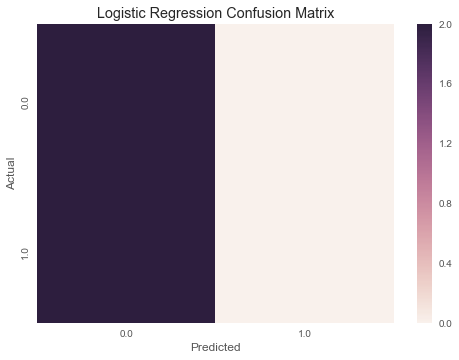

In [147]:
# Linear Model Attempt
log_reg = LogisticRegressionCV(Cs=20)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
report = classification_report(y_test, y_pred)
cm = ConfusionMatrix(y_test, y_pred)

print(report)
cm.plot(backend='seaborn')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

             precision    recall  f1-score   support

          0       0.43      0.30      0.35        10
          1       0.30      0.43      0.35         7

avg / total       0.38      0.35      0.35        17



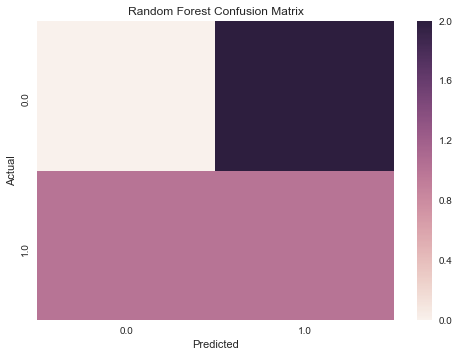

In [144]:
# Random Forest Attempt
rf = RandomForestClassifier(n_estimators=30)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
report = classification_report(y_test, y_pred)
cm = ConfusionMatrix(y_test, y_pred)

print(report)
cm.plot(backend='seaborn')
plt.title('Random Forest Confusion Matrix')
plt.show()

In [ ]:
# Add points of interest and weakness

In [ ]:
# Submit the data and notebook to Professor Nelson